In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from larcv import larcv
import math
%matplotlib inline

In [53]:
filename = '/Users/mdeltutt/Downloads/inference_test_3d_n10_r6_mb64_bpl2_nf32_lrstriangle_clr.h5.pkl'
df_3d = pd.read_pickle(filename)

filename = '/Users/mdeltutt/Downloads/inference_test_2d_n1_r6_mb64_bpl2_nf32_lrstriangle_clr.h5.pkl'
df_2d = pd.read_pickle(filename)

In [3]:
df_3d.head()

,pot,nu_pdg,nu_e,nu_vtx_x,nu_vtx_y,nu_vtx_z,n_voxels,true_neutrinoid,pred_neutrinoid,pred_nue,...,lep_thetayz,lep_dep_e,em_dep_e,tot_dep_e,lead_prot_p,lead_prot_costheta,lead_cpi_p,lead_cpi_costheta,lead_npi_p,lead_npi_costheta
0,0.037060,12.0,8.340893,160.139183,-96.574303,190.383341,-9999.0,0.0,0.0,0.997390,...,-2.272058,-9999.0,0.0,3407.206286,1.484414,0.835170,0.037404,0.434756,0.405313,0.793764
1,1.265881,14.0,3.513449,198.261240,-82.345651,80.454648,-9999.0,2.0,2.0,0.006045,...,-9999.000000,-9999.0,0.0,1803.024971,2.669511,0.933394,0.403407,0.520601,-9999.000000,-9999.000000
2,1.265881,-14.0,4.071934,193.362328,-7.598883,363.141290,-9999.0,2.0,2.0,0.005907,...,-9999.000000,-9999.0,0.0,1596.790205,0.601268,0.427700,0.985521,0.804471,-9999.000000,-9999.000000
3,1.265881,14.0,3.963477,151.660744,-91.552009,161.575285,-9999.0,2.0,2.0,0.159561,...,-9999.000000,-9999.0,0.0,1104.882544,0.646172,0.848752,0.570449,0.450572,1.097229,0.847671
4,3.963065,14.0,2.568464,258.919305,94.004678,178.865133,-9999.0,1.0,1.0,0.019049,...,7.752486,-9999.0,0.0,522.509839,1.045217,0.777005,0.073694,-0.359039,-9999.000000,-9999.000000


In [4]:
df_2d.head()

,pot,nu_pdg,nu_e,nu_vtx_x,nu_vtx_y,nu_vtx_z,n_voxels,true_neutrinoid,pred_neutrinoid,pred_nue,...,lep_thetayz,lep_dep_e,em_dep_e,tot_dep_e,lead_prot_p,lead_prot_costheta,lead_cpi_p,lead_cpi_costheta,lead_npi_p,lead_npi_costheta
0,0.037060,12.0,8.340893,160.139183,-96.574303,190.383341,-9999.0,0.0,2.0,0.135617,...,-2.272058,-9999.0,0.0,3407.206286,1.484414,0.835170,0.037404,0.434756,0.405313,0.793764
1,1.265881,14.0,3.513449,198.261240,-82.345651,80.454648,-9999.0,2.0,1.0,0.065916,...,-9999.000000,-9999.0,0.0,1803.024971,2.669511,0.933394,0.403407,0.520601,-9999.000000,-9999.000000
2,1.265881,-14.0,4.071934,193.362328,-7.598883,363.141290,-9999.0,2.0,2.0,0.007433,...,-9999.000000,-9999.0,0.0,1596.790205,0.601268,0.427700,0.985521,0.804471,-9999.000000,-9999.000000
3,1.265881,14.0,3.963477,151.660744,-91.552009,161.575285,-9999.0,2.0,2.0,0.248752,...,-9999.000000,-9999.0,0.0,1104.882544,0.646172,0.848752,0.570449,0.450572,1.097229,0.847671
4,3.963065,14.0,2.568464,258.919305,94.004678,178.865133,-9999.0,1.0,1.0,0.004958,...,7.752486,-9999.0,0.0,522.509839,1.045217,0.777005,0.073694,-0.359039,-9999.000000,-9999.000000


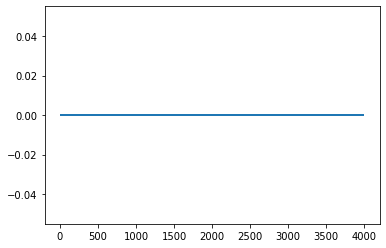

In [5]:
bins, edges, _ = plt.hist(df_3d.query('true_neutrinoid == 2')['n_voxels'].values, histtype='step', lw=2, 
                               bins=20, range=[0,4000])

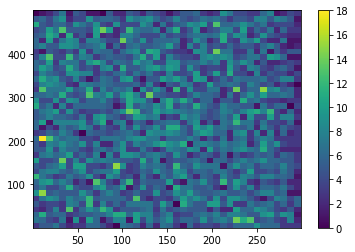

In [6]:
plt.hist2d(df_3d.query('true_neutrinoid == 0')['nu_vtx_x'].values, 
           df_3d.query('true_neutrinoid == 0')['nu_vtx_z'].values,
          bins=[40,40])

plt.colorbar()
plt.show()

In [7]:
import scipy.stats

def pot_scale_factor(this_pot, target = 1e20):
    
    return target / this_pot

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [ ]:
# POT Scaling Factors
# pot_scale_nue_3d  = pot_scale_factor(this_pot=np.sum(nue_df_3d['pot']))
# pot_scale_numu_3d = pot_scale_factor(this_pot=np.sum(numu_df_3d['pot']))
# pot_scale_nc_3d   = pot_scale_factor(this_pot=np.sum(nc_df_3d['pot']))
# pot_scale_nue_2d  = pot_scale_factor(this_pot=np.sum(nue_df_2d['pot']))
# pot_scale_numu_2d = pot_scale_factor(this_pot=np.sum(numu_df_2d['pot']))
# pot_scale_nc_2d   = pot_scale_factor(this_pot=np.sum(nc_df_2d['pot']))

pot_scale_nue_3d  = nue_df_3d['pot'].values[0]
pot_scale_numu_3d = numu_df_3d['pot'].values[0]
pot_scale_nc_3d   = nc_df_3d['pot'].values[0]
pot_scale_nue_2d  = nue_df_2d['pot'].values[0]
pot_scale_numu_2d = numu_df_2d['pot'].values[0]
pot_scale_nc_2d   = nc_df_2d['pot'].values[0]

# numu_df_3d['pot'].values[0]

In [96]:
name = 'neutrinoid'

signal = 0

this_max = 1000

nue_df_3d = df_3d.query('true_'+name+' == 0')
numu_df_3d = df_3d.query('true_'+name+' == 1')
nc_df_3d = df_3d.query('true_'+name+' == 2')

nue_df_2d = df_2d.query('true_'+name+' == 0')
numu_df_2d = df_2d.query('true_'+name+' == 1')
nc_df_2d = df_2d.query('true_'+name+' == 2')

s_3d = float(len(nue_df_3d))
b_3d = float(len(numu_df_3d) + len(nc_df_3d))

s_2d = float(len(nue_df_2d))
b_2d = float(len(numu_df_2d) + len(nc_df_2d))

fom_y_2d = []
fom_y_3d = []
fom_x = []

for x in range(this_max):
    
    th = (x/float(this_max))
    
    nue_sel_df_3d = df_3d.query('true_'+name+' == 0 and pred_'+name+'_'+ str(signal)+' >= '+str(th))
    numu_sel_df_3d = df_3d.query('true_'+name+' == 1 and pred_'+name+'_'+ str(signal)+' >= '+str(th))
    nc_sel_df_3d = df_3d.query('true_'+name+' == 2 and pred_'+name+'_'+ str(signal)+' >= '+str(th))

    nue_sel_df_2d = df_2d.query('true_'+name+' == 0 and pred_'+name+'_'+ str(signal)+' >= '+str(th))
    numu_sel_df_2d = df_2d.query('true_'+name+' == 1 and pred_'+name+'_'+ str(signal)+' >= '+str(th))
    nc_sel_df_2d = df_2d.query('true_'+name+' == 2 and pred_'+name+'_'+ str(signal)+' >= '+str(th))
    
#     eff_s_3d = len(nue_sel_df_3d) / s_3d
#     eff_b_3d = (len(numu_sel_df_3d) + len(nc_sel_df_3d))/ b_3d
    eff_s_3d = len(nue_sel_df_3d) * pot_scale_nue_3d
    eff_b_3d = (len(numu_sel_df_3d) * pot_scale_numu_3d + len(nc_sel_df_3d)) * pot_scale_nc_3d
    
    fom_3d = 0
    if eff_b_3d != 0:
        fom_3d = eff_s_3d / math.sqrt(eff_s_3d + eff_b_3d)
        
#     eff_s_2d = len(nue_sel_df_2d) / s_2d
#     eff_b_2d = (len(numu_sel_df_2d) + len(nc_sel_df_2d))/ b_2d
    eff_s_2d = len(nue_sel_df_2d) * pot_scale_nue_2d
    eff_b_2d = (len(numu_sel_df_2d) * pot_scale_numu_2d + len(nc_sel_df_2d)) * pot_scale_nc_2d
    
    fom_2d = 0
    if eff_b_2d != 0:
        fom_2d = eff_s_2d / math.sqrt(eff_s_2d + eff_b_2d)
        
    fom_x.append(th)
    fom_y_3d.append(fom_3d)
    fom_y_2d.append(fom_2d)    
    
max_idx_3d = np.argmax(fom_y_3d)
x_max_3d = fom_x[max_idx_3d]

max_idx_2d = np.argmax(fom_y_2d)
x_max_2d = fom_x[max_idx_2d]

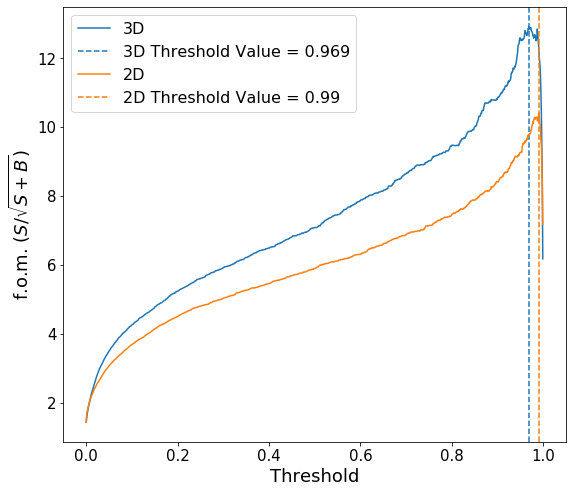

In [97]:
fig = plt.figure(figsize=(9,8),facecolor='w')
plt.figure(1)

plt.plot(fom_x, fom_y_3d, label='3D')
plt.axvline(x_max_3d, color=colors[0], linestyle='--', label='3D Threshold Value = '+str(x_max_3d))

plt.plot(fom_x, fom_y_2d, label='2D')
plt.axvline(x_max_2d, color=colors[1], linestyle='--', label='2D Threshold Value = '+str(x_max_2d))

# plt.plot(x, y, label='Original (graph clicked from arXiv:1905.1314v3)')
plt.legend(fontsize=16, loc='best')
plt.ylabel(r'f.o.m. ($S/\sqrt{S+B}$)',fontsize=18)
plt.xlabel('Threshold',fontsize=18)
# plt.text(1310, 140, "DATA\nEnergy was normalized\nduring training and inference", size=18, wrap=True, ha='left')
plt.tick_params(labelsize=15)

plt.savefig('fom.pdf')
plt.show()

In [98]:
name = 'neutrinoid'

signal = 0

th_3d = x_max_3d
th_2d = x_max_2d

nue_df_3d = df_3d.query('true_'+name+' == 0')
nue_sel_df_3d = df_3d.query('true_'+name+' == 0 and pred_'+name+'_'+ str(signal)+' >= '+str(th_3d))

numu_df_3d = df_3d.query('true_'+name+' == 1')
numu_sel_df_3d = df_3d.query('true_'+name+' == 1 and pred_'+name+'_'+ str(signal)+' >= '+str(th_3d))

nc_df_3d = df_3d.query('true_'+name+' == 2')
nc_sel_df_3d = df_3d.query('true_'+name+' == 2 and pred_'+name+'_'+ str(signal)+' >= '+str(th_3d))

nue_df_2d = df_2d.query('true_'+name+' == 0')
nue_sel_df_2d = df_2d.query('true_'+name+' == 0 and pred_'+name+'_'+ str(signal)+' >= '+str(th_2d))

numu_df_2d = df_2d.query('true_'+name+' == 1')
numu_sel_df_2d = df_2d.query('true_'+name+' == 1 and pred_'+name+'_'+ str(signal)+' >= '+str(th_2d))

nc_df_2d = df_2d.query('true_'+name+' == 2')
nc_sel_df_2d = df_2d.query('true_'+name+' == 2 and pred_'+name+'_'+ str(signal)+' >= '+str(th_2d))

nue 3D - S/B =  2.3559318
nue 2D - S/B =  1.6385852
nue 3D - S/sqrt(S+B) =  11.728199
nue 2D - S/sqrt(S+B) =  9.260044


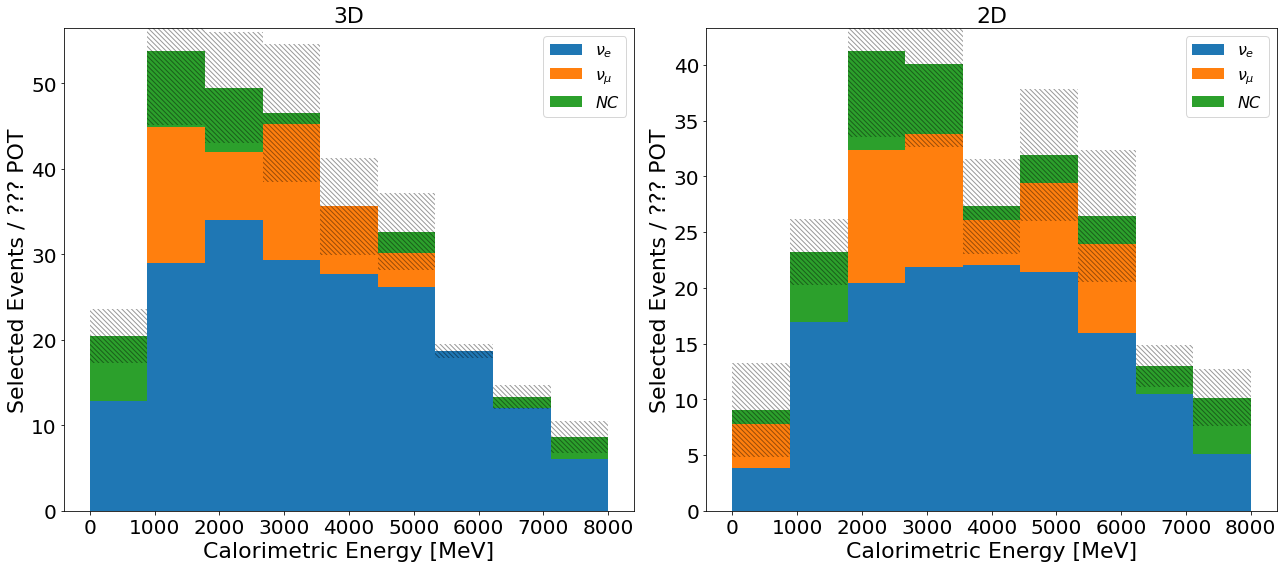

In [99]:
from tools import *

variable = 'lep_e'
xlabel='Lepton Energy [MeV]'
x_range = [0, 8000]
n_bins = 9

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18, 8))

# plot_histogram(ax[0], [nue_sel_df_3d['lep_dep_e'].values, numu_sel_df_3d['em_dep_e'].values, nc_sel_df_3d['em_dep_e'].values],
#                weights=[[pot_scale_nue_3d]*len(nue_sel_df_3d), [pot_scale_numu_3d]*len(numu_sel_df_3d), [pot_scale_nc_3d]*len(nc_sel_df_3d)], 
#                n_bins=20, limits=x_range, option='stacked')

t_3d = plot_histogram(ax[0], [nue_sel_df_3d['tot_dep_e'].values, numu_sel_df_3d['tot_dep_e'].values, nc_sel_df_3d['tot_dep_e'].values],
                      weights=[[pot_scale_nue_3d]*len(nue_sel_df_3d), [pot_scale_numu_3d]*len(numu_sel_df_3d), [pot_scale_nc_3d]*len(nc_sel_df_3d)], 
                      n_bins=n_bins, limits=x_range, option='stacked',
                      label=['$\\nu_e$', '$\\nu_\\mu$', '$NC$'])

# plot_histogram(ax[1], nue_sel_df_3d[variable].values,
#                weights=[pot_scale_nue_3d]*len(nue_sel_df_3d), 
#                n_bins=20, limits=x_range)

t_2d = plot_histogram(ax[1], [nue_sel_df_2d['tot_dep_e'].values, numu_sel_df_2d['tot_dep_e'].values, nc_sel_df_2d['tot_dep_e'].values],
                      weights=[[pot_scale_nue_2d]*len(nue_sel_df_2d), [pot_scale_numu_2d]*len(numu_sel_df_2d), [pot_scale_nc_2d]*len(nc_sel_df_2d)], 
                     n_bins=n_bins, limits=x_range, option='stacked',
                     label=['$\\nu_e$', '$\\nu_\\mu$', '$NC$'])

ax[0].legend(fontsize=16, loc='best')
ax[1].legend(fontsize=16, loc='best')

ax[0].tick_params(labelsize=20)
ax[1].tick_params(labelsize=20)

ax[0].set_xlabel('Calorimetric Energy [MeV]', fontsize=22)
ax[1].set_xlabel('Calorimetric Energy [MeV]', fontsize=22)

ax[0].set_ylabel('Selected Events / ??? POT', fontsize=22)
ax[1].set_ylabel('Selected Events / ??? POT', fontsize=22)

ax[0].set_title('3D', loc='center', fontsize=22)
ax[1].set_title('2D', loc='center', fontsize=22)

fig.tight_layout()

s_b_3d = t_3d[0] / (t_3d[1] + t_3d[2])
s_b_2d = t_2d[0] / (t_2d[1] + t_2d[2])

if signal == 0:
    print ('nue 3D - S/B = ', t_3d[0] / (t_3d[1] + t_3d[2]))
    print ('nue 2D - S/B = ', t_2d[0] / (t_2d[1] + t_2d[2]))
    print ('nue 3D - S/sqrt(S+B) = ', t_3d[0] / np.sqrt(t_3d[0] + t_3d[1] + t_3d[2]))
    print ('nue 2D - S/sqrt(S+B) = ', t_2d[0] / np.sqrt(t_2d[0] + t_2d[1] + t_2d[2]))

if signal == 1:
    print ('numu 3D - S/B = ', t_3d[1] / (t_3d[0] + t_3d[2]))
    print ('numu 2D - S/B = ', t_2d[1] / (t_2d[0] + t_2d[2]))
    print ('numu 3D - S/sqrt(S+B) = ', t_3d[1] / np.sqrt(t_3d[0] + t_3d[1] + t_3d[2]))
    print ('numu 2D - S/sqrt(S+B) = ', t_2d[1] / np.sqrt(t_2d[0] + t_2d[1] + t_2d[2]))

plt.savefig('sig_bkg_stacked_sig'+str(signal)+'.pdf')
plt.show()


In [100]:

variable = 'tot_dep_e'
variable = 'nu_e'
x_range = [0, 8]
data_h, err, bins, bins_mid = histogram_helper([nue_sel_df_3d[variable].values, numu_sel_df_3d[variable].values, nc_sel_df_3d[variable].values], 
                                               [[pot_scale_nue_3d]*len(nue_sel_df_3d), [pot_scale_numu_3d]*len(numu_sel_df_3d), [pot_scale_nc_3d]*len(nc_sel_df_3d)], 
                                               n_bins=n_bins, limits=x_range)

data_h_sig, err, bins, bins_mid = histogram_helper(numu_df_3d[variable].values, 
                                                  [pot_scale_numu_3d]*len(numu_df_3d), 
                                                  n_bins=n_bins, limits=x_range)

total_events = [0.] * n_bins
bkg_events = [0.] * n_bins
sig_events = [0.] * n_bins
sig_all_events = data_h_sig
print (sig_all_events)

purity = [0.] * n_bins
efficiency = [0.] * n_bins

for i, sample in enumerate(data_h):
    for j, events_per_bin in enumerate(sample):
        total_events[j] += events_per_bin
        if i != signal:
            bkg_events[j] += events_per_bin
        else:
            sig_events[j] += events_per_bin

# for j, events_per_bin in enumerate(data_h_sig):
    
    
for i, p in enumerate(purity):
#     print('bin', i, ', sig', sig_events[i], ', tot', total_events[i], ', pur', purity[i])
    purity[i] = sig_events[i] / total_events[i]
    efficiency[i] = sig_events[i] / sig_all_events[i]
    print('bin', i, ', sig', sig_events[i], ', tot', total_events[i], ', pur', purity[i], ', eff', efficiency[i])



[ 408.19583 3091.204   6522.9546  8373.589   7200.5723  3836.0781
 2135.998   1398.998   1046.7188 ]
bin 0 , sig 2.334765911102295 , tot 2.334765911102295 , pur 1.0 , eff 0.005719720124709166
bin 1 , sig 12.192668914794922 , tot 13.458550333976746 , pur 0.9059422160805799 , eff 0.003944310538612425
bin 2 , sig 18.048110961914062 , tot 19.313992381095886 , pur 0.9344578068478042 , eff 0.002766861352984888
bin 3 , sig 21.605854034423828 , tot 42.356218338012695 , pur 0.5100987501292956 , eff 0.0025802382200883892
bin 4 , sig 22.345760345458984 , tot 36.601295471191406 , pur 0.6105182906175318 , eff 0.003103331168848342
bin 5 , sig 22.307693481445312 , tot 34.031463623046875 , pur 0.6555020297845209 , eff 0.005815234402048397
bin 6 , sig 23.493484497070312 , tot 31.419612884521484 , pur 0.7477330985399923 , eff 0.010998832387249448
bin 7 , sig 24.0531005859375 , tot 25.318981170654297 , pur 0.9500027044459434 , eff 0.017193090897922203
bin 8 , sig 23.350067138671875 , tot 31.2761993408203

[0.         0.88888889 1.77777778 2.66666667 3.55555556 4.44444444
 5.33333333 6.22222222 7.11111111 8.        ] [1.0, 0.5396665304743632, 0.2378237259886033, 0.12290213271021032, 0.13677399377227628, 0.1786064216741948, 0.22470214466884175, 0.29528630513441734, 0.26792782966632905]


(0, 1)

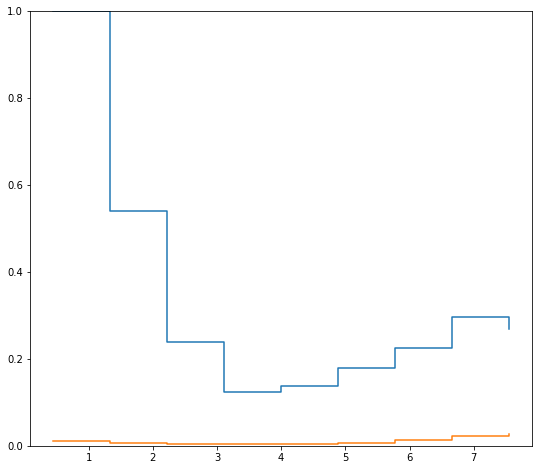

In [89]:
fig = plt.figure(figsize=(9,8),facecolor='w')
print (bins, purity)
plt.step(bins_mid, purity, where="post", label='sss')
plt.step(bins_mid, efficiency, where="post", label='sss')

plt.ylim(0, 1)


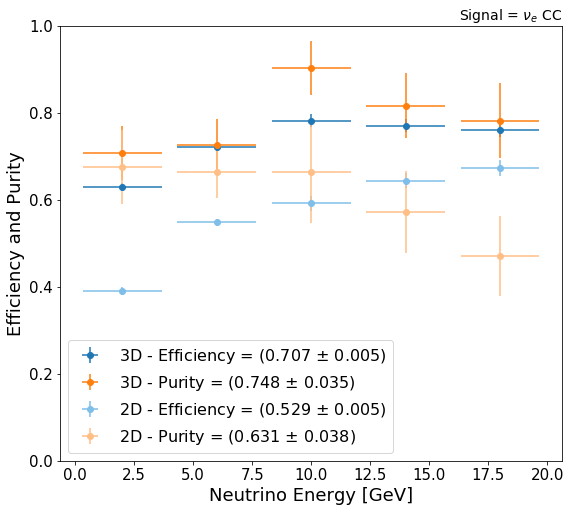

In [103]:
from tools import *
 
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,8))
ax = [ax]

x_range = [0, 20]
n_bins =6

if signal == 0:
    eff_numerator = nue_sel_df_3d[variable].values
    eff_numerator_w = [pot_scale_nue_3d]*len(nue_sel_df_3d)
    eff_denominator = nue_df_3d[variable].values
    eff_denominator_w = [pot_scale_nue_3d]*len(nue_df_3d)

    pur_numerator = nue_sel_df_3d[variable].values
    pur_numerator_w = [pot_scale_nue_3d]*len(nue_sel_df_3d)
    
if signal == 1:
    eff_numerator = numu_sel_df_3d[variable].values
    eff_numerator_w = [pot_scale_numu_3d]*len(numu_sel_df_3d)
    eff_denominator = numu_df_3d[variable].values
    eff_denominator_w = [pot_scale_numu_3d]*len(numu_df_3d)

    pur_numerator = numu_sel_df_3d[variable].values
    pur_numerator_w = [pot_scale_numu_3d]*len(numu_sel_df_3d)
    
pur_denominator = np.concatenate((nue_sel_df_3d[variable].values, numu_sel_df_3d[variable].values, nc_sel_df_3d[variable].values))
pur_denominator_w = np.concatenate(([pot_scale_nue_3d]*len(nue_sel_df_3d), [pot_scale_numu_3d]*len(numu_sel_df_3d), [pot_scale_nc_3d]*len(nc_sel_df_3d)))


eff_3d, unc_low_3d, unc_up_3d, bins_3d, bins_mid_3d, unc_x_3d = efficiency(num=eff_numerator, 
                                                             den=eff_denominator, 
                                                             num_w=eff_numerator_w, 
                                                             den_w=eff_denominator_w, 
                                                             n_bins=n_bins, 
                                                             limits=x_range)

tot_eff_3d = float(len(eff_numerator)) / len(eff_denominator)
tot_err_eff_3d = np.sqrt(float(len(eff_numerator))*(1-float(len(eff_numerator))/len(eff_denominator)))/len(eff_denominator)

ax[0].errorbar(bins_mid_3d, eff_3d, 
                      yerr=[unc_low_3d, unc_up_3d], xerr=unc_x_3d,
                      fmt='o',
                      color=colors[0],
                      label='3D - Efficiency = ({0:0.3f} $\\pm$ {1:0.3f})'.format(tot_eff_3d, tot_err_eff_3d))
    
pur_3d, unc_low_3d, unc_up_3d, bins_3d, bins_mid_3d, unc_x_3d = efficiency(num=pur_numerator, 
                                                             den=pur_denominator, 
                                                             num_w=pur_numerator_w, 
                                                             den_w=pur_denominator_w, 
                                                             n_bins=n_bins, 
                                                             limits=x_range)

tot_pur_3d, tot_err_pur_3d, _, _, _, _ = efficiency(num=pur_numerator,den=pur_denominator,
                                                    num_w=pur_numerator_w,den_w=pur_denominator_w, 
                                                    n_bins=2,limits=x_range)

ax[0].errorbar(bins_mid_3d, pur_3d, 
                      yerr=[unc_low_3d, unc_up_3d], xerr=unc_x_3d,
                      fmt='o',
               color=colors[1],
                      label='3D - Purity = ({0:0.3f} $\\pm$ {1:0.3f})'.format(tot_pur_3d[0], tot_err_pur_3d[0]))


########################

if signal == 0:
    eff_numerator = nue_sel_df_2d[variable].values
    eff_numerator_w = [pot_scale_nue_2d]*len(nue_sel_df_2d)
    eff_denominator = nue_df_2d[variable].values
    eff_denominator_w = [pot_scale_nue_2d]*len(nue_df_2d)

    pur_numerator = nue_sel_df_2d[variable].values
    pur_numerator_w = [pot_scale_nue_2d]*len(nue_sel_df_2d)
    
if signal == 1:
    eff_numerator = numu_sel_df_2d[variable].values
    eff_numerator_w = [pot_scale_numu_2d]*len(numu_sel_df_2d)
    eff_denominator = numu_df_2d[variable].values
    eff_denominator_w = [pot_scale_numu_2d]*len(numu_df_2d)

    pur_numerator = numu_sel_df_2d[variable].values
    pur_numerator_w = [pot_scale_numu_2d]*len(numu_sel_df_2d)
    
pur_denominator = np.concatenate((nue_sel_df_2d[variable].values, numu_sel_df_2d[variable].values, nc_sel_df_2d[variable].values))
pur_denominator_w = np.concatenate(([pot_scale_nue_2d]*len(nue_sel_df_2d), [pot_scale_numu_2d]*len(numu_sel_df_2d), [pot_scale_nc_2d]*len(nc_sel_df_2d)))

x_range=[0, 20]
eff_2d, unc_low_2d, unc_up_2d, bins_2d, bins_mid_2d, unc_x_2d = efficiency(num=eff_numerator, 
                                                             den=eff_denominator, 
                                                             num_w=eff_numerator_w, 
                                                             den_w=eff_denominator_w, 
                                                             n_bins=n_bins, 
                                                             limits=x_range)

tot_eff_2d = float(len(eff_numerator)) / len(eff_denominator)
tot_err_eff_2d = np.sqrt(float(len(eff_numerator))*(1-float(len(eff_numerator))/len(eff_denominator)))/len(eff_denominator)

ax[0].errorbar(bins_mid_2d, eff_2d, 
                      yerr=[unc_low_2d, unc_up_2d], xerr=unc_x_2d,
                      fmt='o',
                      color=lighten_color(colors[0]),
                      label='2D - Efficiency = ({0:0.3f} $\\pm$ {1:0.3f})'.format(tot_eff_2d, tot_err_eff_2d))
    
    
    
pur_2d, unc_low_2d, unc_up_2d, bins_2d, bins_mid_2d, unc_x_2d = efficiency(num=pur_numerator, 
                                                             den=pur_denominator, 
                                                             num_w=pur_numerator_w, 
                                                             den_w=pur_denominator_w, 
                                                             n_bins=n_bins, 
                                                             limits=x_range)

tot_pur_2d, tot_err_pur_2d, _, _, _, _ = efficiency(num=pur_numerator,den=pur_denominator,
                                                    num_w=pur_numerator_w,den_w=pur_denominator_w, 
                                                    n_bins=2,limits=x_range)

ax[0].errorbar(bins_mid_2d, pur_2d, 
                      yerr=[unc_low_2d, unc_up_2d], xerr=unc_x_2d,
                      fmt='o',
                      color=lighten_color(colors[1]),
#                       linestyle='--',
                      label='2D - Purity = ({0:0.3f} $\\pm$ {1:0.3f})'.format(tot_pur_2d[0], tot_err_pur_2d[0]))

ax[0].legend(fontsize=16, loc='best')
plt.ylabel('Efficiency and Purity',fontsize=18)
ax[0].set_xlabel('Neutrino Energy [GeV]',fontsize=18)
if signal == 0: top_label = r'Signal = $\nu_e$ CC'
if signal == 1: top_label = r'Signal = $\nu_\mu$ CC'
plt.title(top_label, loc='right', fontsize=14)
ax[0].tick_params(labelsize=15)
ax[0].set_ylim(0, 1)

plt.savefig('eff_pur_2d_3d_sig'+str(signal)+'.pdf')
plt.show()

In [81]:
name = 'neutrinoid'
# name = 'prot'
# name = 'cpi'
# name = 'npi'

# signal = 0 # nue, prot0, cpi = 0, npi = 0
signal = 1 # numu, prot1, cpi > 0, npi > 0
# signal = 2 # nc, prot2

if name == 'neutrinoid':
    if signal == 0: signal_txt = '$\\nu_{e}$'
    if signal == 1: signal_txt = '$\\nu_{\\mu}$'
    if signal == 2: signal_txt = '$NC$'

if name == 'prot':
    if signal == 0: signal_txt = '$N_{p} = 0$'
    if signal == 1: signal_txt = '$N_{p} = 1$'
    if signal == 2: signal_txt = '$N_{p} > 1$'
        
if name == 'cpi':
    if signal == 0: signal_txt = '$N_{\\pi^{\\pm}} = 0$'
    if signal == 1: signal_txt = '$N_{\\pi^{\\pm}} > 0$'

if name == 'npi':
    if signal == 0: signal_txt = '$N_{\\pi^{0}} = 0$'
    if signal == 1: signal_txt = '$N_{\\pi^{0}} > 0$'


nue_df_3d = df_3d.query('true_'+name+' == ' + str(signal))
nue_sel_df_3d = df_3d.query('true_'+name+' == ' + str(signal) + ' and pred_'+name+' == ' + str(signal))

nue_df_2d = df_2d.query('true_'+name+' == ' + str(signal))
nue_sel_df_2d = df_2d.query('true_'+name+' == ' + str(signal) + ' and pred_'+name+' == ' + str(signal))

In [ ]:
variable = 'lep_e'
xlabel='Lepton Energy [MeV]'
x_range = [0, 2500]

# variable = 'lep_costheta'
# xlabel='cos($\\theta_{lep}$)'
# x_range = [-1, 1]

# variable = 'lead_prot_p'
# xlabel='Leading Proton Momentum [MeV]'
# x_range = [0, 2000]

# variable = 'lead_prot_costheta'
# xlabel='Leading Proton cos($\\theta_p$)'
# x_range = [-1, 1]

# variable = 'lead_cpi_p'
# xlabel='Leading $\\pi^{\\pm}$ Momentum [MeV]'
# x_range = [0, 1500]

# variable = 'lead_cpi_costheta'
# xlabel='Leading Proton $\\pi^{\\pm}$ cos($\\theta_{\\pi^{\\pm}}$)'
# x_range = [-1, 1]

# variable = 'lead_npi_p'
# xlabel='Leading $\\pi^{0}$ Momentum [MeV]'
# x_range = [0, 1]

# variable = 'lead_npi_costheta'
# xlabel='Leading Proton $\\pi^{0}$ cos($\\theta_{\\pi^{0}}$)'
# x_range = [-1, 1]

print ('Overall efficiency - 3D:', float(len(nue_sel_df_3d)) / len(nue_df_3d))
print ('Overall efficiency - 2D:', float(len(nue_sel_df_2d)) / len(nue_df_2d))

pot_scale_3d = pot_scale_factor(this_pot=np.sum(nue_df_3d['pot']))
pot_scale_2d = pot_scale_factor(this_pot=np.sum(nue_df_2d['pot']))

nue_df_3d = nue_df_3d.query(variable + ' > -9999')
nue_sel_df_3d = nue_sel_df_3d.query(variable + ' > -9999')
nue_df_2d = nue_df_2d.query(variable + ' > -9999')
nue_sel_df_2d = nue_sel_df_2d.query(variable + ' > -9999')

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20,14), sharex=True, sharey=False)


# 3D - left

bins, edges, _ = ax[0][0].hist([nue_df_3d[variable].values,nue_sel_df_3d[variable].values], histtype='step', lw=2, 
                               color = ['#ff7f0e', '#2ca02c'], 
                               label = ['Signal: '+signal_txt, 'Selected Signal'], 
                               weights=[[pot_scale_3d]*len(nue_df_3d), [pot_scale_3d]*len(nue_sel_df_3d)],
                               bins=20,
                               range=x_range)

eff_3d, unc_low_3d, unc_up_3d, bins_3d, bins_mid_3d, unc_x_3d = efficiency(num=nue_sel_df_3d[variable].values, 
                                                         den=nue_df_3d[variable].values, 
                                                         num_w=[pot_scale_3d]*len(nue_sel_df_3d), 
                                                         den_w=[pot_scale_3d]*len(nue_df_3d), 
                                                         n_bins=20, 
                                                         limits=x_range)

tot_eff_3d = float(len(nue_sel_df_3d)) / len(nue_df_3d)
tot_err_eff_3d = np.sqrt(float(len(nue_sel_df_3d))*(1-float(len(nue_sel_df_3d))/len(nue_df_3d)))/len(nue_df_3d)

ax[1][0].errorbar(bins_mid_3d, eff_3d, 
                  yerr=[unc_low_3d, unc_up_3d], xerr=unc_x_3d,
                  fmt='o',
                  color='#d62728',
                  label='Efficiency = ({0:0.2f} $\\pm$ {1:0.2f})%'.format(tot_eff_3d, tot_err_eff_3d))



# 2D - right

bins, edges, _ = ax[0][1].hist([nue_df_2d[variable],nue_sel_df_2d[variable]], histtype='step', lw=2, 
                               color = ['#ff7f0e', '#2ca02c'], 
                               label = ['Signal: '+signal_txt, 'Selected Signal'], 
                               weights=[[pot_scale_2d]*len(nue_df_2d), [pot_scale_2d]*len(nue_sel_df_2d)],
                               bins=20,
                               range=x_range)

eff_2d, unc_low_2d, unc_up_2d, bins_2d, bins_mid_2d, unc_x_2d = efficiency(num=nue_sel_df_2d[variable].values, 
                                                         den=nue_df_2d[variable].values, 
                                                         num_w=[pot_scale_2d]*len(nue_sel_df_2d), 
                                                         den_w=[pot_scale_2d]*len(nue_df_2d), 
                                                         n_bins=20, 
                                                         limits=x_range)

tot_eff_2d = float(len(nue_sel_df_2d)) / len(nue_df_2d)
tot_err_eff_2d = np.sqrt(float(len(nue_sel_df_2d))*(1-float(len(nue_sel_df_2d))/len(nue_df_2d)))/len(nue_df_2d)

ax[1][1].errorbar(bins_mid_2d, eff_2d, 
                  yerr=[unc_low_2d, unc_up_2d], xerr=unc_x_2d,
                  fmt='o',
                  color='#d62728',
                  label='Efficiency = ({0:0.2f} $\\pm$ {1:0.2f})%'.format(tot_eff_2d, tot_err_eff_2d))



fsize = 22

# Left settings

ax[0][0].set_ylabel('Events / $1.0 \\times 10^{20}$ POT', fontsize=fsize) # nue
# ax[0][0].set_ylabel('Events / $5.2 \\times 10^{19}$ POT', fontsize=fsize) # nue
# ax[0][0].set_ylabel('Events / $4.5 \\times 10^{17}$ POT', fontsize=fsize) # numu

ax[1][0].set_xlabel(xlabel, fontsize=fsize)
ax[1][0].set_ylabel('Signal selection efficiency', fontsize=fsize)

ax[0][0].tick_params(labelsize=20)
ax[1][0].tick_params(labelsize=20)

ax[0][0].legend(fontsize=18, loc='best')
ax[1][0].legend(fontsize=18, loc=3)
ax[1][0].set_ylim(0,1)
ax[1][0].set_xlim(x_range[0], x_range[1])


# Right settings

ax[0][1].set_ylabel('Events / $1.0 \\times 10^{20}$ POT', fontsize=fsize) # nue
# ax[0][1].set_ylabel('Events / $5.2 \\times 10^{19}$ POT', fontsize=fsize) # nue
# ax[0][1].set_ylabel('Events / $4.5 \\times 10^{17}$ POT', fontsize=fsize) # numu

ax[1][1].set_xlabel(xlabel, fontsize=fsize)
ax[1][1].set_ylabel('Signal selection efficiency', fontsize=fsize)

ax[0][1].tick_params(labelsize=20)
ax[1][1].tick_params(labelsize=20)

ax[0][1].legend(fontsize=18, loc='best')
ax[1][1].legend(fontsize=18, loc=3)
ax[1][1].set_ylim(0,1)
ax[1][1].set_xlim(x_range[0], x_range[1])


fig.tight_layout()

plt.savefig('selected_events_efficiency_'+name+'_sig'+str(signal)+'_'+variable+'.pdf')
plt.show()



# Number of protons

In [ ]:
name = 'neutrinoid'
# name = 'prot'
# name = 'cpi'
# name = 'npi'

# signal = 0 # nue, prot0, cpi = 0, npi = 0
signal = 1 # numu, prot1, cpi > 0, npi > 0
# signal = 2 # nc, prot2

if name == 'neutrinoid':
    if signal == 0: signal_txt = '$\\nu_{e}$'
    if signal == 1: signal_txt = '$\\nu_{\\mu}$'
    if signal == 2: signal_txt = '$NC$'

if name == 'prot':
    if signal == 0: signal_txt = '$N_{p} = 0$'
    if signal == 1: signal_txt = '$N_{p} = 1$'
    if signal == 2: signal_txt = '$N_{p} > 1$'
        
if name == 'cpi':
    if signal == 0: signal_txt = '$N_{\\pi^{\\pm}} = 0$'
    if signal == 1: signal_txt = '$N_{\\pi^{\\pm}} > 0$'

if name == 'npi':
    if signal == 0: signal_txt = '$N_{\\pi^{0}} = 0$'
    if signal == 1: signal_txt = '$N_{\\pi^{0}} > 0$'


nue_df_3d = df_3d.query('true_'+name+' == ' + str(signal))
nue_sel_df_3d = df_3d.query('true_'+name+' == ' + str(signal) + ' and pred_'+name+' == ' + str(signal))

nue_df_2d = df_2d.query('true_'+name+' == ' + str(signal))
nue_sel_df_2d = df_2d.query('true_'+name+' == ' + str(signal) + ' and pred_'+name+' == ' + str(signal))

In [ ]:
def make_plots(name, signal_txt, var, str_sig, str_sig_sel, df_3d, df_2d):
    
    sig_df_3d = df_3d.query(str_sig)
    sig_sel_df_3d = df_3d.query(str_sig_sel)

    sig_df_2d = df_2d.query(str_sig)
    sig_sel_df_2d = df_2d.query(str_sig_sel)

    print ('Overall efficiency - 3D:', float(len(sig_sel_df_3d)) / len(sig_df_3d))
    print ('Overall efficiency - 2D:', float(len(sig_sel_df_2d)) / len(sig_df_2d))

    pot_scale_3d = pot_scale_factor(this_pot=np.sum(sig_df_3d['pot']))
    pot_scale_2d = pot_scale_factor(this_pot=np.sum(sig_df_2d['pot']))
    
    sig_df_3d = sig_df_3d.query(var.variable + ' > -9999')
    sig_sel_df_3d = sig_sel_df_3d.query(var.variable + ' > -9999')
    sig_df_2d = sig_df_2d.query(var.variable + ' > -9999')
    sig_sel_df_2d = sig_sel_df_2d.query(var.variable + ' > -9999')


    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20,14), sharex=True, sharey=False)

    # 3D - left

    bins, edges, _ = ax[0][0].hist([sig_df_3d[var.variable].values,sig_sel_df_3d[var.variable].values], histtype='step', lw=2, 
                                   color = ['#ff7f0e', '#2ca02c'], 
                                   label = ['Signal: '+signal_txt, 'Selected Signal'], 
                                   weights=[[pot_scale_3d]*len(sig_df_3d), [pot_scale_3d]*len(sig_sel_df_3d)],
                                   bins=20,
                                   range=[var.x_1, var.x_2])

    eff_3d, unc_low_3d, unc_up_3d, bins_3d, bins_mid_3d, unc_x_3d = efficiency(num=sig_sel_df_3d[var.variable].values, 
                                                             den=sig_df_3d[var.variable].values, 
                                                             num_w=[pot_scale_3d]*len(sig_sel_df_3d), 
                                                             den_w=[pot_scale_3d]*len(sig_df_3d), 
                                                             n_bins=20, 
                                                             limits=[var.x_1, var.x_2])

    tot_eff_3d = float(len(sig_sel_df_3d)) / len(sig_df_3d)
    tot_err_eff_3d = np.sqrt(float(len(sig_sel_df_3d))*(1-float(len(sig_sel_df_3d))/len(sig_df_3d)))/len(sig_df_3d)

    ax[1][0].errorbar(bins_mid_3d, eff_3d, 
                      yerr=[unc_low_3d, unc_up_3d], xerr=unc_x_3d,
                      fmt='o',
                      color='#d62728',
                      label='Efficiency = ({0:0.2f} $\\pm$ {1:0.2f})%'.format(tot_eff_3d, tot_err_eff_3d))



    # 2D - right

    bins, edges, _ = ax[0][1].hist([sig_df_2d[var.variable],sig_sel_df_2d[var.variable]], histtype='step', lw=2, 
                                   color = ['#ff7f0e', '#2ca02c'], 
                                   label = ['Signal: '+signal_txt, 'Selected Signal'], 
                                   weights=[[pot_scale_2d]*len(sig_df_2d), [pot_scale_2d]*len(sig_sel_df_2d)],
                                   bins=20,
                                   range=[var.x_1, var.x_2])

    eff_2d, unc_low_2d, unc_up_2d, bins_2d, bins_mid_2d, unc_x_2d = efficiency(num=sig_sel_df_2d[var.variable].values, 
                                                             den=sig_df_2d[var.variable].values, 
                                                             num_w=[pot_scale_2d]*len(sig_sel_df_2d), 
                                                             den_w=[pot_scale_2d]*len(sig_df_2d), 
                                                             n_bins=20, 
                                                             limits=[var.x_1, var.x_2])

    tot_eff_2d = float(len(sig_sel_df_2d)) / len(sig_df_2d)
    tot_err_eff_2d = np.sqrt(float(len(sig_sel_df_2d))*(1-float(len(sig_sel_df_2d))/len(sig_df_2d)))/len(sig_df_2d)

    ax[1][1].errorbar(bins_mid_2d, eff_2d, 
                      yerr=[unc_low_2d, unc_up_2d], xerr=unc_x_2d,
                      fmt='o',
                      color='#d62728',
                      label='Efficiency = ({0:0.2f} $\\pm$ {1:0.2f})%'.format(tot_eff_2d, tot_err_eff_2d))



    fsize = 22

    # Left settings

    ax[0][0].set_ylabel('Events / $1.0 \\times 10^{20}$ POT', fontsize=fsize) # nue
    # ax[0][0].set_ylabel('Events / $5.2 \\times 10^{19}$ POT', fontsize=fsize) # nue
    # ax[0][0].set_ylabel('Events / $4.5 \\times 10^{17}$ POT', fontsize=fsize) # numu

    ax[1][0].set_xlabel(var.xlabel, fontsize=fsize)
    ax[1][0].set_ylabel('Signal selection efficiency', fontsize=fsize)

    ax[0][0].tick_params(labelsize=20)
    ax[1][0].tick_params(labelsize=20)

    ax[0][0].legend(fontsize=18)
    ax[1][0].legend(fontsize=18, loc=3)
    ax[1][0].set_ylim(0,1)


    # Right settings

    ax[0][1].set_ylabel('Events / $1.0 \\times 10^{20}$ POT', fontsize=fsize) # nue
    # ax[0][1].set_ylabel('Events / $5.2 \\times 10^{19}$ POT', fontsize=fsize) # nue
    # ax[0][1].set_ylabel('Events / $4.5 \\times 10^{17}$ POT', fontsize=fsize) # numu

    ax[1][1].set_xlabel(var.xlabel, fontsize=fsize)
    ax[1][1].set_ylabel('Signal selection efficiency', fontsize=fsize)

    ax[0][1].tick_params(labelsize=20)
    ax[1][1].tick_params(labelsize=20)

    ax[0][1].legend(fontsize=18)
    ax[1][1].legend(fontsize=18, loc=3)
    ax[1][1].set_ylim(0,1)


    fig.tight_layout()

    plt.savefig('selected_events_efficiency_'+name+'_'+var.variable+'.pdf')
    plt.show()
    
    
    
    
    fig = plt.figure(figsize=(9,8),facecolor='w')

    plt.errorbar(bins_mid_3d, eff_3d, 
                      yerr=[unc_low_3d, unc_up_3d], xerr=unc_x_3d,
                      fmt='o',
                      label='3D - Efficiency = ({0:0.2f} $\\pm$ {1:0.2f})%'.format(tot_eff_3d, tot_err_eff_3d))

    plt.errorbar(bins_mid_2d, eff_2d, 
                      yerr=[unc_low_2d, unc_up_2d], xerr=unc_x_2d,
                      fmt='o',
                      label='2D - Efficiency = ({0:0.2f} $\\pm$ {1:0.2f})%'.format(tot_eff_2d, tot_err_eff_2d))

    plt.xlabel(var.xlabel, fontsize=fsize)
    plt.ylabel('Signal selection efficiency', fontsize=fsize)

    plt.legend(fontsize=16, loc='best')
    # plt.title('SBND Sparse Data', loc='right', fontsize=14)
    plt.tick_params(labelsize=15)
    plt.ylim(0,1)

    plt.savefig('selected_events_efficiency_both_'+name+'_'+var.variable+'.pdf')
    plt.show()

In [ ]:
# https://stackoverflow.com/questions/35988/c-like-structures-in-python/31062667
from dataclasses import dataclass

@dataclass
class Variable:
    variable: str = 'lep_e'
    xlabel: str = 'Lepton Energy [MeV]'
    x_1: float = 0.0
    x_2: float = 2500.

all_vars = {
    'lep_p':               Variable(variable = 'lep_e', xlabel = 'Lepton Energy [MeV]', x_1 = 0.0, x_2 = 2500.),
    'lep_costheta':        Variable(variable = 'lep_costheta', xlabel = 'cos($\\theta_{lep}$)', x_1 = -1., x_2 = 1.),
    'lead_prot_p':         Variable(variable = 'lead_prot_p', xlabel = 'Leading Proton Momentum [MeV]', x_1 = 0., x_2 = 2000.),
    'lead_prot_costheta':  Variable(variable = 'lead_prot_costheta', xlabel = 'Leading Proton cos($\\theta_p$)', x_1 = 0., x_2 = 2000.),
}
# p = Variable(variable = 'lep_costheta', xlabel = 'cos($\\theta_{lep}$)', x_1 = -1., x_2 = 2500.)
# print (p.variable)

# sig = 0

# sig_df_3d = df_3d.query('true_neutrinoid == ' + str(signal))
# sig_sel_df_3d = df_3d.query('true_neutrinoid == ' + str(signal) + ' and pred_neutrinoid == ' + str(signal))

# sig_df_2d = df_2d.query('true_neutrinoid == ' + str(signal))
# sig_sel_df_2d = df_2d.query('true_neutrinoid == ' + str(signal) + ' and pred_neutrinoid == ' + str(signal))

# sel_str = 'true_neutrinoid == ' + str(signal)
# sel_str_sel = 'true_neutrinoid == ' + str(signal) + ' and pred_neutrinoid == ' + str(signal)





categories = [
    {
        'name'       : "nue_cc",
        'signal'     : "true_neutrinoid == 0",
        'signal_sel' : "true_neutrinoid == 0 and pred_neutrinoid == 0",
        'var'        : [all_vars['lep_p'], all_vars['lep_costheta']],
        'label'      : r"$\nu_e$ CC"
    },
    {
        'name'       : "numu_cc",
        'signal'     : "true_neutrinoid == 1",
        'signal_sel' : "true_neutrinoid == 1 and pred_neutrinoid == 1",
        'var'        : [all_vars['lep_p'], all_vars['lep_costheta']],
        'label'      : r"$\nu_{\mu}$ CC"
    },
    {
        'name'       : "nue_cc_0p",
        'signal'     : "true_neutrinoid == 0 and true_prot == 0",
        'signal_sel' : "true_neutrinoid == 0 and true_prot == 0 and pred_neutrinoid == 0 and pred_prot == 0",
        'var'        : [all_vars['lep_p'], all_vars['lep_costheta']],
        'label'      : r"$\nu_e CC$, $N_{p} = 0$"
    },
    {
        'name'       : "nue_cc_1p",
        'signal'     : "true_neutrinoid == 0 and true_prot == 1",
        'signal_sel' : "true_neutrinoid == 0 and true_prot == 1 and pred_neutrinoid == 0 and pred_prot == 1",
        'var'        : [all_vars['lep_p'], all_vars['lep_costheta'], all_vars['lead_prot_p'], all_vars['lead_prot_costheta']],
        'label'      : r"$\nu_e$ CC, $N_{p} = 1$"
    },
    {
        'name'       : "nue_cc_2p",
        'signal'     : "true_neutrinoid == 0 and true_prot == 2",
        'signal_sel' : "true_neutrinoid == 0 and true_prot == 2 and pred_neutrinoid == 0 and pred_prot == 2",
        'var'        : [all_vars['lep_p'], all_vars['lep_costheta'], all_vars['lead_prot_p'], all_vars['lead_prot_costheta']],
        'label'      : r"$\nu_e$ CC, $N_{p} > 1$"
    }
]


c = categories[0]
for v in c['var']:
    print (c['name'])
    print (c['signal'], c['signal_sel'])
    
    make_plots(c['name'], c['label'], v, c['signal'], c['signal_sel'], df_3d, df_2d)
#     break
    



In [ ]:

variable = 'lep_e'
xlabel='Lepton Energy [MeV]'
x_range = [0, 2500]

# variable = 'lep_costheta'
# xlabel='cos($\\theta_{lep}$)'
# x_range = [-1, 1]

# variable = 'lead_prot_p'
# xlabel='Leading Proton Momentum [MeV]'
# x_range = [0, 2000]

# variable = 'lead_prot_costheta'
# xlabel='Leading Proton cos($\\theta_p$)'
# x_range = [-1, 1]

# variable = 'lead_cpi_p'
# xlabel='Leading $\\pi^{\\pm}$ Momentum [MeV]'
# x_range = [0, 1500]

# variable = 'lead_cpi_costheta'
# xlabel='Leading Proton $\\pi^{\\pm}$ cos($\\theta_{\\pi^{\\pm}}$)'
# x_range = [-1, 1]

# variable = 'lead_npi_p'
# xlabel='Leading $\\pi^{0}$ Momentum [MeV]'
# x_range = [0, 1]

# variable = 'lead_npi_costheta'
# xlabel='Leading Proton $\\pi^{0}$ cos($\\theta_{\\pi^{0}}$)'
# x_range = [-1, 1]

print ('Overall efficiency - 3D:', float(len(nue_sel_df_3d)) / len(nue_df_3d))
print ('Overall efficiency - 2D:', float(len(nue_sel_df_2d)) / len(nue_df_2d))

pot_scale_3d = pot_scale_factor(this_pot=np.sum(nue_df_3d['pot']))
pot_scale_2d = pot_scale_factor(this_pot=np.sum(nue_df_2d['pot']))

nue_df_3d = nue_df_3d.query(variable + ' > -9999')
nue_sel_df_3d = nue_sel_df_3d.query(variable + ' > -9999')
nue_df_2d = nue_df_2d.query(variable + ' > -9999')
nue_sel_df_2d = nue_sel_df_2d.query(variable + ' > -9999')

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20,14), sharex=True, sharey=False)


# 3D - left

bins, edges, _ = ax[0][0].hist([nue_df_3d[variable].values,nue_sel_df_3d[variable].values], histtype='step', lw=2, 
                               color = ['#ff7f0e', '#2ca02c'], 
                               label = ['Signal: '+signal_txt, 'Selected Signal'], 
                               weights=[[pot_scale_3d]*len(nue_df_3d), [pot_scale_3d]*len(nue_sel_df_3d)],
                               bins=20,
                               range=x_range)

eff_3d, unc_low_3d, unc_up_3d, bins_3d, bins_mid_3d, unc_x_3d = efficiency(num=nue_sel_df_3d[variable].values, 
                                                         den=nue_df_3d[variable].values, 
                                                         num_w=[pot_scale_3d]*len(nue_sel_df_3d), 
                                                         den_w=[pot_scale_3d]*len(nue_df_3d), 
                                                         n_bins=20, 
                                                         limits=x_range)

tot_eff_3d = float(len(nue_sel_df_3d)) / len(nue_df_3d)
tot_err_eff_3d = np.sqrt(float(len(nue_sel_df_3d))*(1-float(len(nue_sel_df_3d))/len(nue_df_3d)))/len(nue_df_3d)

ax[1][0].errorbar(bins_mid_3d, eff_3d, 
                  yerr=[unc_low_3d, unc_up_3d], xerr=unc_x_3d,
                  fmt='o',
                  color='#d62728',
                  label='Efficiency = ({0:0.2f} $\\pm$ {1:0.2f})%'.format(tot_eff_3d, tot_err_eff_3d))



# 2D - right

bins, edges, _ = ax[0][1].hist([nue_df_2d[variable],nue_sel_df_2d[variable]], histtype='step', lw=2, 
                               color = ['#ff7f0e', '#2ca02c'], 
                               label = ['Signal: '+signal_txt, 'Selected Signal'], 
                               weights=[[pot_scale_2d]*len(nue_df_2d), [pot_scale_2d]*len(nue_sel_df_2d)],
                               bins=20,
                               range=x_range)

eff_2d, unc_low_2d, unc_up_2d, bins_2d, bins_mid_2d, unc_x_2d = efficiency(num=nue_sel_df_2d[variable].values, 
                                                         den=nue_df_2d[variable].values, 
                                                         num_w=[pot_scale_2d]*len(nue_sel_df_2d), 
                                                         den_w=[pot_scale_2d]*len(nue_df_2d), 
                                                         n_bins=20, 
                                                         limits=x_range)

tot_eff_2d = float(len(nue_sel_df_2d)) / len(nue_df_2d)
tot_err_eff_2d = np.sqrt(float(len(nue_sel_df_2d))*(1-float(len(nue_sel_df_2d))/len(nue_df_2d)))/len(nue_df_2d)

ax[1][1].errorbar(bins_mid_2d, eff_2d, 
                  yerr=[unc_low_2d, unc_up_2d], xerr=unc_x_2d,
                  fmt='o',
                  color='#d62728',
                  label='Efficiency = ({0:0.2f} $\\pm$ {1:0.2f})%'.format(tot_eff_2d, tot_err_eff_2d))



fsize = 22

# Left settings

ax[0][0].set_ylabel('Events / $1.0 \\times 10^{20}$ POT', fontsize=fsize) # nue
# ax[0][0].set_ylabel('Events / $5.2 \\times 10^{19}$ POT', fontsize=fsize) # nue
# ax[0][0].set_ylabel('Events / $4.5 \\times 10^{17}$ POT', fontsize=fsize) # numu

ax[1][0].set_xlabel(xlabel, fontsize=fsize)
ax[1][0].set_ylabel('Signal selection efficiency', fontsize=fsize)

ax[0][0].tick_params(labelsize=20)
ax[1][0].tick_params(labelsize=20)

ax[0][0].legend(fontsize=18, loc='best')
ax[1][0].legend(fontsize=18, loc=3)
ax[1][0].set_ylim(0,1)
ax[1][0].set_xlim(x_range[0], x_range[1])


# Right settings

ax[0][1].set_ylabel('Events / $1.0 \\times 10^{20}$ POT', fontsize=fsize) # nue
# ax[0][1].set_ylabel('Events / $5.2 \\times 10^{19}$ POT', fontsize=fsize) # nue
# ax[0][1].set_ylabel('Events / $4.5 \\times 10^{17}$ POT', fontsize=fsize) # numu

ax[1][1].set_xlabel(xlabel, fontsize=fsize)
ax[1][1].set_ylabel('Signal selection efficiency', fontsize=fsize)

ax[0][1].tick_params(labelsize=20)
ax[1][1].tick_params(labelsize=20)

ax[0][1].legend(fontsize=18, loc='best')
ax[1][1].legend(fontsize=18, loc=3)
ax[1][1].set_ylim(0,1)
ax[1][1].set_xlim(x_range[0], x_range[1])


fig.tight_layout()

plt.savefig('selected_events_efficiency_'+name+'_sig'+str(signal)+'_'+variable+'.pdf')
plt.show()


